___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://cdn.shopify.com/s/files/1/0057/9158/0227/files/iStock-688127540_b9b55e84-98ae-4483-a559-a371b91da77f.jpg?v=1737413205" width="380px" height="200px" />


# <font color= #bbc28d> **Project 1 - Autoencoders** </font>
#### <font color= #2E9AFE> `Data Cleaning/Processing`</font>

<br><br><br>
___

<p style="text-align:right; font-size:12px;" > Image retrieved from: https://cdn.shopify.com/s/files/1/0057/9158/0227/files/iStock-688127540_b9b55e84-98ae-4483-a559-a371b91da77f.jpg?v=1737413205</p>

# <font color=#bbc28d> **Introduction** </font>
This notebook focuses on the **cleaning**, **preprocessing**, and **preparation** of image data used throughout the autoencoder experiments in this project. Proper preprocessing is a critical step in any computer vision pipeline, as it directly impacts training stability, convergence behavior, and reconstruction quality.

**`Note`**: Due to local hardware and storage limitations, all data cleaning and preprocessing steps in this notebook were executed using Google Colab.

In [ ]:
# Import general modules
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt

# <font color=#bbc28d> **Environment Preparation** </font>

Google Drive is mounted into the Google Colab environment. This allows the notebook to directly access files stored in cloud storage, such as datasets and preprocessed outputs.

In [ ]:
from google.colab import drive

# Conect our google drive to colab's environment
drive.mount("/content/drive")

Mounted at /content/drive


Here we extract the compressed dataset archive stored in Google Drive into the Colab filesystem. This step makes the image files and metadata accessible for preprocessing without requiring repeated downloads.

In [ ]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/fashion_data.zip", "r") as zip_ref:
    zip_ref.extractall("/content/fashion_data")

This section defines all dataset paths and preprocessing parameters used throughout the notebook.

In [3]:
IMG_DIR = "/content/fashion_data/Images"
CSV_PATH = "/content/fashion_data/fashion.csv"
OUT_DIR = "/content/drive/MyDrive/processed"

IMG_SIZE = 256
IMG_COL = "Image"
LABEL_COL = "SubCategory"

os.makedirs(OUT_DIR, exist_ok=True)

# <font color=#bbc28d> **Data Processing** </font>
## <font color= #66b0b0>• **RGB Image Preprocessing** </font>
Each image is converted to RGB, resized while preserving aspect ratio, and center-cropped to a fixed **square** resolution. Pixel values are normalized to the **[0,1]** range to stabilize neural network training. 

Corresponding **labels** are extracted from the metadata file and encoded into numerical form using a label encoder. Finally, the processed images, labels, and encoder are saved for model training.

In [ ]:
# Function to center objects and resize them
def resize_to_square(img, size=IMG_SIZE):
    img = img.convert("RGB")
    w, h = img.size
    scale = size / min(w, h)
    img = img.resize((int(w*scale), int(h*scale)), Image.BICUBIC)

    left = (img.width - size) // 2
    top = (img.height - size) // 2
    return img.crop((left, top, left + size, top + size))


In [ ]:
# Read file with id and category
df = pd.read_csv(CSV_PATH)

images, labels = [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(IMG_DIR, row[IMG_COL])
    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path)

    # Re-size them
    img = resize_to_square(img)

    # Normalize and save image
    images.append(np.asarray(img, dtype=np.float32) / 255.0)

    # Save label
    labels.append(row[LABEL_COL])

X = np.array(images, dtype=np.float32)

le = LabelEncoder()
y = le.fit_transform(labels)

# Save in Google Drive
np.save(f"{OUT_DIR}/X_images.npy", X)
np.save(f"{OUT_DIR}/y_labels.npy", y)

with open(f"{OUT_DIR}/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


100%|██████████| 2906/2906 [02:53<00:00, 16.79it/s]


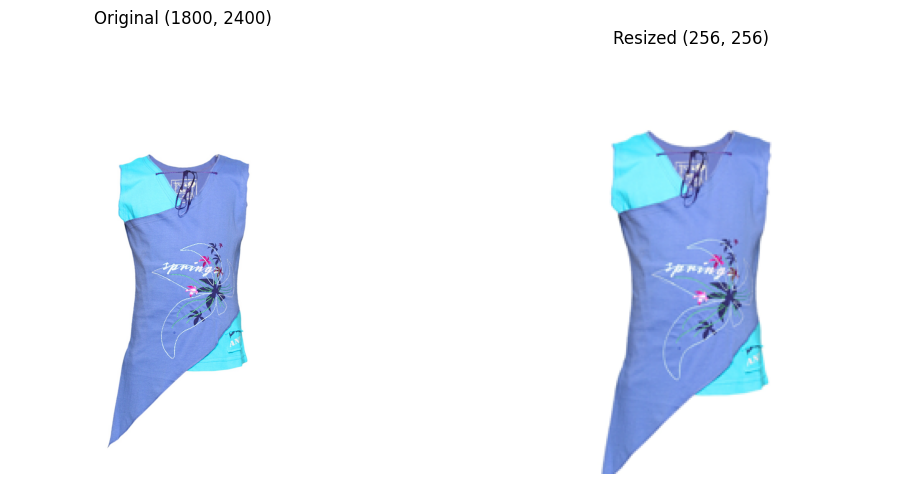

In [ ]:
# Open the original image
img = Image.open("/content/fashion_data/Images/5414.jpg")
sq = resize_to_square(img)  # your function

# Compare original vs processed
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

# Original image
axes[0].imshow(img)
axes[0].set_title(f"Original {img.size}")
axes[0].axis("off")

# Square / resized image
axes[1].imshow(sq)
axes[1].set_title(f"Resized {sq.size}")
axes[1].axis("off")

plt.show()


In [ ]:
# Load everything back
X = np.load("/content/drive/MyDrive/processed/X_images.npy")
y = np.load("/content/drive/MyDrive/processed/y_labels.npy")

with open("/content/drive/MyDrive/processed/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# See all class -> number mappings
for i, class_name in enumerate(le.classes_):
    print(f"{i} -> {class_name}")

0 -> Apparel Set
1 -> Bottomwear
2 -> Dress
3 -> Flip Flops
4 -> Innerwear
5 -> Sandal
6 -> Shoes
7 -> Socks
8 -> Topwear


In [ ]:
# Optional: Save them locally on the disk
from google.colab import files
files.download("/content/drive/MyDrive/processed/X_images.npy")
files.download("/content/drive/MyDrive/processed/y_labels.npy")
files.download("/content/drive/MyDrive/processed/label_encoder.pkl")

## <font color= #66b0b0>• **Grayscale Image Preprocessing** </font>
This section implements an alternative preprocessing pipeline that converts all images to **grayscale** before resizing and normalization. Reducing images to a single channel **lowers input dimensionality** and computational cost, making it useful for experiments that focus on structural features and shape reconstruction rather than color information.

The preprocessing steps mirror those used for RGB images, ensuring comparability between experiments. A channel dimension is explicitly added at the end to maintain compatibility with convolutional neural networks.

In [ ]:
# Function to center objects, resize, normalize and change to grayscale
def resize_to_square_grayscale(img, size=256):
    img = img.convert("L")   # grayscale (1 channel)
    w, h = img.size

    scale = size / min(w, h)
    img = img.resize(
        (int(w * scale), int(h * scale)),
        Image.BICUBIC
    )

    left = (img.width - size) // 2
    top  = (img.height - size) // 2

    return img.crop((left, top, left + size, top + size))

In [ ]:
df = pd.read_csv(CSV_PATH)

images, labels = [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(IMG_DIR, row[IMG_COL])
    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path)

    # Resize and make grayscale
    img = resize_to_square_grayscale(img)

    # Normalize image and save
    images.append(np.asarray(img, dtype=np.float32) / 255.0)

    # Save label
    labels.append(row[LABEL_COL])

X = np.array(images, dtype=np.float32)
X = X[..., np.newaxis]   # add channel dimension
le = LabelEncoder()
y = le.fit_transform(labels)

np.save(f"{OUT_DIR}/X_images_gray.npy", X)
np.save(f"{OUT_DIR}/y_labels_gray.npy", y)

with open(f"{OUT_DIR}/label_encoder_gray.pkl", "wb") as f:
    pickle.dump(le, f)

100%|██████████| 2906/2906 [01:50<00:00, 26.29it/s]


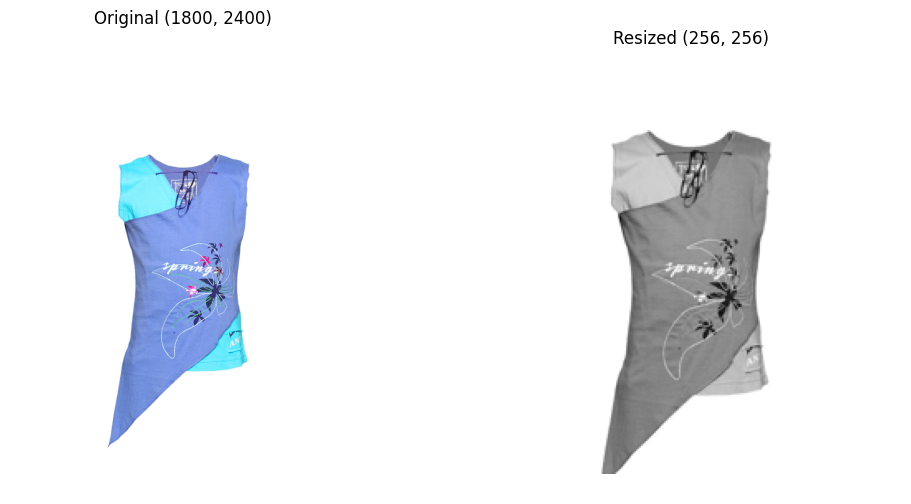

In [ ]:
# Open the original image
img = Image.open("/content/fashion_data/Images/5414.jpg")
sq = resize_to_square_grayscale(img)  # your function

# Compare original vs processed
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img)
axes[0].set_title(f"Original {img.size}")
axes[0].axis("off")

# Square / resized image
axes[1].imshow(sq, cmap="gray")
axes[1].set_title(f"Resized {sq.size}")
axes[1].axis("off")

plt.show()


In [ ]:
# Optional: Save files locally
files.download("/content/drive/MyDrive/processed/X_images_gray.npy")
files.download("/content/drive/MyDrive/processed/y_labels_gray.npy")
files.download("/content/drive/MyDrive/processed/label_encoder_gray.pkl")

In [ ]:
# Load everything
y = np.load("/content/drive/MyDrive/processed/y_labels_gray.npy")

with open("/content/drive/MyDrive/processed/label_encoder_gray.pkl", "rb") as f:
    le = pickle.load(f)

# Decode the whole y array back to names
label_names = le.inverse_transform(y)

# See all class -> number mappings
for i, class_name in enumerate(le.classes_):
    print(f"{i} -> {class_name}")

0 -> Apparel Set
1 -> Bottomwear
2 -> Dress
3 -> Flip Flops
4 -> Innerwear
5 -> Sandal
6 -> Shoes
7 -> Socks
8 -> Topwear


## <font color= #66b0b0>• **Noise Injecting** </font>
This section demonstrates the procedure used to generate noisy versions of the input images, a standard requirement for training denoising autoencoders. Gaussian noise is added to the normalized image tensors using a fixed noise factor, simulating realistic corruption while preserving the overall image structure. After noise injection, pixel values are clipped to the [0,1] range.

**`Note:`** Although this approach is correct, storing the full noisy dataset is almost impossible without saturating your computer's RAM, and therefore noise was generated during training in the experiments.

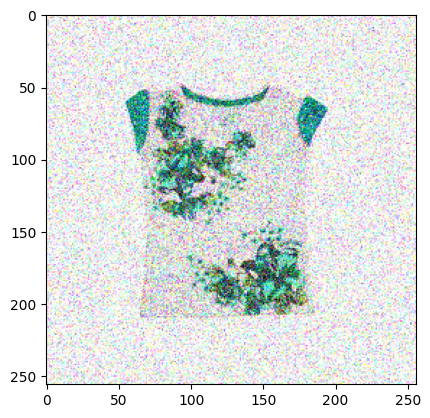

In [ ]:
# Scale of how much noise to add
noise_factor = 0.2

# Add noise 
X_noisy = X + noise_factor * np.random.normal(0.0, 1.0, X.shape)

# Clip values to stay within [0,1]
np.clip(X_noisy, 0.0, 1.0, out=X_noisy)

# Plot an example
plt.imshow(X_noisy[0])
plt.show()

In [ ]:
# Save noisy images 
np.save(f"{OUT_DIR}/X_noisy.npy", X_noisy)

In [ ]:
# Optional: Save file locally
files.download("/content/drive/MyDrive/processed/X_noisy.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>